In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_log = pd.read_csv("SRP073813_log.csv")
df_meta = pd.read_csv("SRP073813_meta.csv")
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True)
df_meta = df_meta['refinebio_subject']

In [3]:
df_meta = df_meta.to_frame()
df_log =round(df_log)
df_log = df_log.T
df_log = df_log.join(df_meta)

In [4]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()]
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')]
df_log.set_index("refinebio_subject", inplace = True)

In [5]:
df_log = df_log.T

In [6]:
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)

In [41]:
dfTen = df.head(10).T
dfHun = df.head(100).T
dfThous = df.head(1000).T
dfFiveThous = df.head(5000).T
dfTenThous = df.head(10000).T

In [42]:
dfFiveThous.keys()

Index(['CHI3L1', 'PENK', 'PTPN5', 'SYNDIG1L', 'XIST', 'HSPA1A', 'RAP1GAP',
       'PEG3', 'MOBP', 'NRGN',
       ...
       'KLHDC7B', 'ADAM20', 'SCFD1', 'MMP28', 'VLDLR', 'ENAM', 'LINC01980',
       'ICE2', 'ZXDC', 'LL22NC03-63E9.3'],
      dtype='object', length=5000)

In [43]:
dfFiveThous.index

Index(['nacc_schizophrenia', 'nacc_control', 'nacc_control',
       'nacc_schizophrenia', 'nacc_control', 'nacc_control', 'nacc_control',
       'nacc_control', 'nacc_control', 'nacc_control',
       ...
       'nacc_major depression', 'nacc_bipolar disorder', 'nacc_schizophrenia',
       'nacc_control', 'nacc_major depression', 'nacc_schizophrenia',
       'nacc_schizophrenia', 'nacc_schizophrenia', 'nacc_schizophrenia',
       'variance'],
      dtype='object', name='refinebio_subject', length=115)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def data_split(data1, data2):
    d3 = pd.concat([data1,data2], axis=0).sample(frac=1.0, random_state=42)
    return train_test_split(d3.values,d3.index.values, test_size=0.25,random_state=42)

def data_group(data):
    return data.loc['nacc_schizophrenia'], data.loc['nacc_major depression'], data.loc['nacc_bipolar disorder'], data.loc['nacc_control']

def model_predict(data):
    xTrain,xTest,yTrain, yTest = data
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(xTrain, yTrain)
    y_pred = svm_classifier.predict(xTest)
    return accuracy_score(yTest, y_pred)

def test_for_accuracy(data,numGenes):
    dS, dD, dB, dC = data_group(data)
    print("Model accuracy for top " + numGenes + " genes, classifying Schizophrenia vs. Control: " + str(model_predict(data_split(dS,dC))))
    print("Model accuracy for top " + numGenes + " genes, classifying Major Depression vs. Control: " + str(model_predict(data_split(dD,dC))))
    print("Model accuracy for top " + numGenes + " genes, classifying Bipolar Disorder vs. Control: " + str(model_predict(data_split(dB,dC))))
    print()
    


    
    
    

In [51]:
test_for_accuracy(dfTen, "10")
test_for_accuracy(dfHun, "100")
test_for_accuracy(dfThous, "1000")
test_for_accuracy(dfFiveThous, "5000")
test_for_accuracy(dfTenThous, "10000")

Model accuracy for top 10 genes, classifying Schizophrenia vs. Control: 0.6153846153846154
Model accuracy for top 10 genes, classifying Major Depression vs. Control: 0.5333333333333333
Model accuracy for top 10 genes, classifying Bipolar Disorder vs. Control: 0.4666666666666667

Model accuracy for top 100 genes, classifying Schizophrenia vs. Control: 0.6923076923076923
Model accuracy for top 100 genes, classifying Major Depression vs. Control: 0.8
Model accuracy for top 100 genes, classifying Bipolar Disorder vs. Control: 0.4666666666666667

Model accuracy for top 1000 genes, classifying Schizophrenia vs. Control: 0.7692307692307693
Model accuracy for top 1000 genes, classifying Major Depression vs. Control: 0.8666666666666667
Model accuracy for top 1000 genes, classifying Bipolar Disorder vs. Control: 0.6

Model accuracy for top 5000 genes, classifying Schizophrenia vs. Control: 0.7692307692307693
Model accuracy for top 5000 genes, classifying Major Depression vs. Control: 0.8
Model a

In [52]:
from sklearn.feature_selection import RFECV

In [79]:
def data_train(data1, data2):
    d3 = pd.concat([data1,data2], axis=0).sample(frac=1.0, random_state=42)
    return d3.values, d3.index.values

def computeSigFeatures(data, step_val, cv_val):
    X_train, y_train = data
    svm = SVC(kernel='linear')
    rfecv = RFECV(estimator=svm, step=step_val, cv=cv_val, scoring='accuracy')
    rfecv.fit(X_train, y_train)
    selected_gene_indices = rfecv.support_
    return selected_gene_indices.tolist()
    
def modelFeatures(data, numGenes, step, cv):
    dS, dD, dB, dC = data_group(data)
    gene_subset = data.columns.tolist()
    featuresS = computeSigFeatures(data_train(dS,dC), step, cv)
    featuresD = computeSigFeatures(data_train(dD,dC), step, cv)
    featuresB = computeSigFeatures(data_train(dB,dC), step, cv)
    sigS = [item for item, should_keep in zip(gene_subset, featuresS) if should_keep]
    sigD = [item for item, should_keep in zip(gene_subset, featuresD) if should_keep]
    sigB = [item for item, should_keep in zip(gene_subset, featuresB) if should_keep]
    print("Number of significant features for top " + numGenes + " variable genes, for classifying Schizophrenia vs. Control: " + str(len(sigS)))
    print("Number of significant features for top " + numGenes + " variable genes, for classifying Major Depression vs. Control: " + str(len(sigD)))
    print("Number of significant features for top " + numGenes + " variable genes, for classifying Bipolar Disorder vs. Control: " + str(len(sigB)))
    print()
    return sigS, sigD, sigB
    
    



In [81]:
mf10 = modelFeatures(dfTen, "10", 1, 3)
mf100 = modelFeatures(dfHun, "100", 2, 3)
mf1000 = modelFeatures(dfThous, "1000", 5, 3)
mf5000 = modelFeatures(dfFiveThous, "5000", 10, 3)
mf10000 = modelFeatures(dfTenThous, "10000", 20, 3)


Number of significant features for top 10 variable genes, for classifying Schizophrenia vs. Control: 5
Number of significant features for top 10 variable genes, for classifying Major Depression vs. Control: 8
Number of significant features for top 10 variable genes, for classifying Bipolar Disorder vs. Control: 7

Number of significant features for top 100 variable genes, for classifying Schizophrenia vs. Control: 26
Number of significant features for top 100 variable genes, for classifying Major Depression vs. Control: 24
Number of significant features for top 100 variable genes, for classifying Bipolar Disorder vs. Control: 36

Number of significant features for top 1000 variable genes, for classifying Schizophrenia vs. Control: 75
Number of significant features for top 1000 variable genes, for classifying Major Depression vs. Control: 200
Number of significant features for top 1000 variable genes, for classifying Bipolar Disorder vs. Control: 105

Number of significant features for 

In [87]:
mf10S, mf10D, mf10B = mf10
mf100S, mf100D, mf100B = mf100
mf1000S, mf1000D, mf1000B = mf1000
mf5000S, mf5000D, mf5000B = mf5000
mf10000S, mf10000D, mf10000B = mf10000

In [90]:
import venn

setS = {
    'mf10_schizophrenia': set(mf10S),
    'mf100_schizophrenia': set(mf100S),
    'mf1000_schizophrenia': set(mf1000S),
    'mf5000_schizophrenia': set(mf5000S),
    'mf10000_schizophrenia': set(mf10000S)
}
setD = {
    'mf10_depression': set(mf10D),
    'mf100_depression': set(mf100D),
    'mf1000_depression': set(mf1000D),
    'mf5000_depression': set(mf5000D),
    'mf10000_depression': set(mf10000D)
}
setB = {
    'mf10_bipolar': set(mf10B),
    'mf100_bipolar': set(mf100B),
    'mf1000_bipolar': set(mf1000B),
    'mf5000_bipolar': set(mf5000B),
    'mf10000_bipolar': set(mf10000B)
}

def plotVenn(sets):
    labels = venn.get_labels([value for key, value in sets.items()], fill=['number'])
    fig, ax = venn.venn5(labels, names=list(sets.keys()))



C:\Users\Srikar\AppData\Local\Programs\Python\Python310\lib\site-packages\venn\_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
C:\Users\Srikar\AppData\Local\Programs\Python\Python310\lib\site-packages\venn\_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


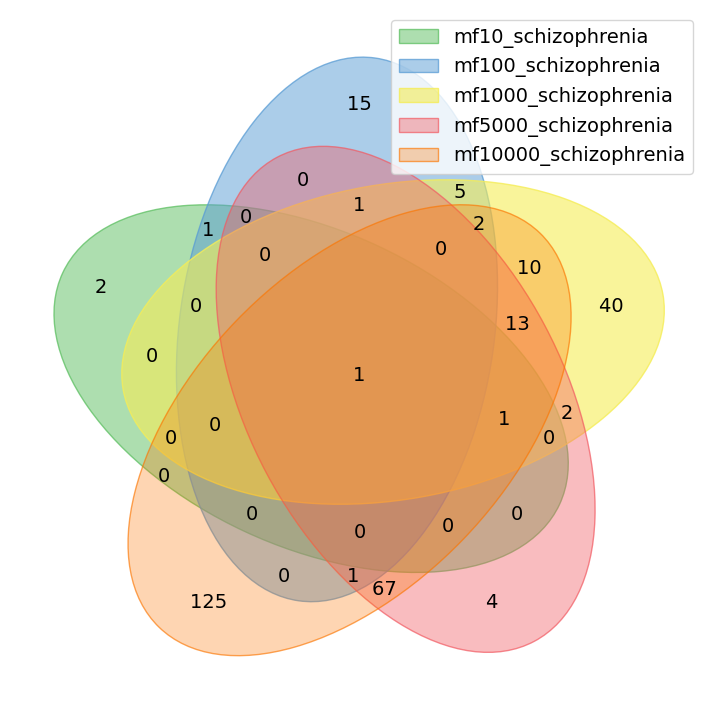

In [91]:
plotVenn(setS)

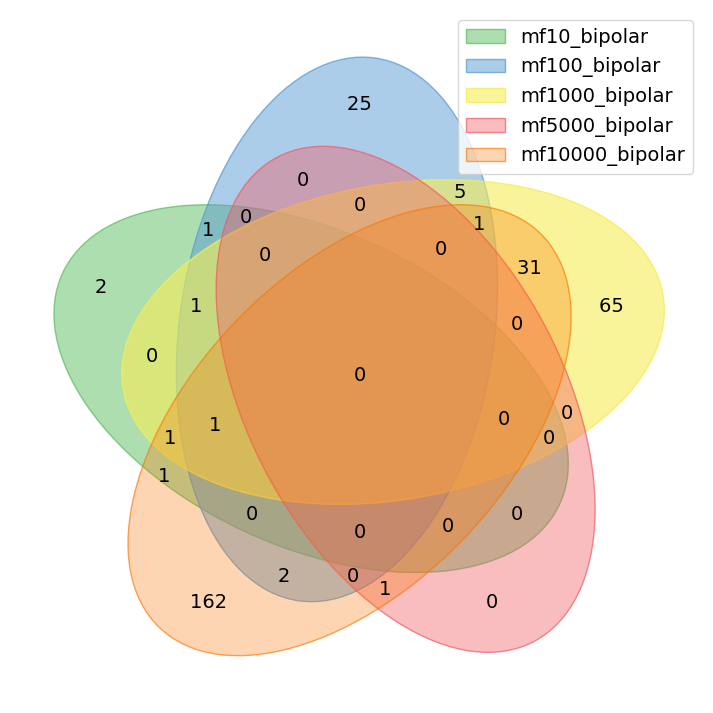

In [92]:
plotVenn(setB)

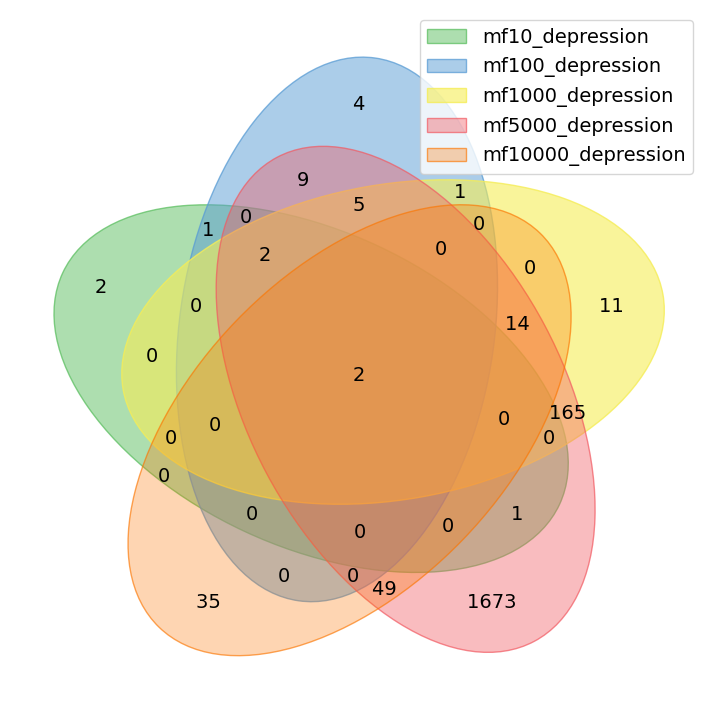

In [93]:
plotVenn(setD)